**Fecha:** 03-02-2025, 10-02-2025, 17-02-2025

**Autor:** _Juan D. Torres Chaparro, B.Eng_

**Materia:** Procesamiento de Alto Volúmen de Datos

**Tópico:** _Introducción a PySpark en el Ambiente Databricks_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import mean, col, split, count, when, lit, isnan

# Extracción de Datos

In [2]:
spark = SparkSession.builder.appName("Taller_Strokes").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Ejcución de las tareas en ", cores, "core(s) del sistema de cómputo actual")
spark

Ejcución de las tareas en  1 core(s) del sistema de cómputo actual


In [3]:
from pyspark import SparkFiles

url_github = "https://raw.githubusercontent.com/corredor-john/ExploratoryDataAnalisys/refs/heads/main/Varios/stroke_pyspark.csv"
spark.sparkContext.addFile(url_github)

df00 = spark.read.csv("file://" + SparkFiles.get("stroke_pyspark.csv"), inferSchema=True, header=True)
df00.show(5)


+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

# Modificación de los Datos

1. Cambiar nombre de las columnas

In [4]:
nuevosNombres = ['id', 'genero', 'edad',
                 'hipertension', 'enfCardiacas', 'estadoCivil',
                 'tipoTrabajo', 'tipoRecidencia', 'promedioGlucosa',
                 'IMC', 'fumador', 'paracardiaco']
df01 = df00

# Hacer cambio de las columbas con 'nuevosNombres'
for antes, nuevo in zip(df00.columns, nuevosNombres):
    df01 = df01.withColumnRenamed(antes, nuevo)

# Mostrar esquema cambiado
df01.printSchema()


root
 |-- id: integer (nullable = true)
 |-- genero: string (nullable = true)
 |-- edad: double (nullable = true)
 |-- hipertension: integer (nullable = true)
 |-- enfCardiacas: integer (nullable = true)
 |-- estadoCivil: string (nullable = true)
 |-- tipoTrabajo: string (nullable = true)
 |-- tipoRecidencia: string (nullable = true)
 |-- promedioGlucosa: double (nullable = true)
 |-- IMC: string (nullable = true)
 |-- fumador: string (nullable = true)
 |-- paracardiaco: integer (nullable = true)



2. Cambiar el tipo de dato en edad e IMC

In [5]:
# Casteo de datos
df01 = df01.withColumn("edad", df01.edad.cast("int"))
df01 = df01.withColumn("IMC", df01.IMC.cast("double"))

# Mostrar esquema nuevo
df01.printSchema()

root
 |-- id: integer (nullable = true)
 |-- genero: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- hipertension: integer (nullable = true)
 |-- enfCardiacas: integer (nullable = true)
 |-- estadoCivil: string (nullable = true)
 |-- tipoTrabajo: string (nullable = true)
 |-- tipoRecidencia: string (nullable = true)
 |-- promedioGlucosa: double (nullable = true)
 |-- IMC: double (nullable = true)
 |-- fumador: string (nullable = true)
 |-- paracardiaco: integer (nullable = true)



# Limpieza de los Datos

1. Detectar cuantos datos nulos hay en cada columna de <code>df01</code>

In [6]:
df01.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df01.columns]).show()

+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+
| id|genero|edad|hipertension|enfCardiacas|estadoCivil|tipoTrabajo|tipoRecidencia|promedioGlucosa|IMC|fumador|paracardiaco|
+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+
|  0|     0|   0|           0|           0|          0|          0|             0|              0|201|      0|           0|
+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+



Se pued observar que la columna IMc presenta datos Nulos o Imposibes. A pesar que el porcentaje de datos nulos son muy bajos, se requiere crear una estrategia para mutar o cambiar los datos, sin que sean eliminados.
-    Se requiere hacer estratos de promedio cada 10 años
-    Los promedios por estratos se catalogan por género
-    Se sustituye por el promedio los nulos según género/estrato_edad

2. Revisamos el número de géneros en <code>df01</code>

In [7]:
#Obtener cantidad total de registros

df01.groupby(['genero']).count().show()

+------+-----+
|genero|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+



2.1. Revisar el resto de datos

In [8]:
df01.groupby('id').count().show()
df01.groupby('edad').count().show()
df01.groupby('hipertension').count().show()
df01.groupby('enfCardiacas').count().show()
df01.groupby('estadoCivil').count().show()
df01.groupby('tipoTrabajo').count().show()
df01.groupby('tipoRecidencia').count().show()
df01.groupby('promedioGlucosa').count().show()
df01.groupby('IMC').count().show()
df01.groupby('fumador').count().show()
df01.groupby('paracardiaco').count().show()


+-----+-----+
|   id|count|
+-----+-----+
|18051|    1|
|18498|    1|
|36355|    1|
|28024|    1|
|54264|    1|
|14832|    1|
|33412|    1|
|48875|    1|
|37307|    1|
|32445|    1|
|47501|    1|
|58061|    1|
| 7754|    1|
|18866|    1|
| 4219|    1|
|66400|    1|
|36706|    1|
|37832|    1|
|25283|    1|
|13622|    1|
+-----+-----+
only showing top 20 rows

+----+-----+
|edad|count|
+----+-----+
|  31|   79|
|  65|   62|
|  53|   85|
|  78|  102|
|  34|   68|
|  81|   60|
|  28|   54|
|  76|   50|
|  27|   55|
|  26|   62|
|  44|   75|
|  12|   45|
|  22|   45|
|  47|   75|
|   1|   77|
|  52|   90|
|  13|   57|
|  16|   52|
|   6|   24|
|   3|   46|
+----+-----+
only showing top 20 rows

+------------+-----+
|hipertension|count|
+------------+-----+
|           1|  498|
|           0| 4612|
+------------+-----+

+------------+-----+
|enfCardiacas|count|
+------------+-----+
|           1|  276|
|           0| 4834|
+------------+-----+

+-----------+-----+
|estadoCivil|count|
+-----

3. Borramos el genero <code>Other</code> por lo despreciable de su valor

In [9]:
#Se descarta el registro cuyo valor en género es 'Other'
df02 = df01.where("genero <> 'Other'")

#Se verifica que ya no este 'Other'
df02.groupby(['genero']).count().show()

+------+-----+
|genero|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
+------+-----+



4. Definimos una función para remplazara los valores nulos de la columna IMC

In [10]:
def fill_imc_for_age_range(df, genero, edad_min, edad_max, avg_val):
    """
    Reemplaza los valores nulos de la columna IMC para un género y rango de edad específicos.

    Parameters:
      df (DataFrame): DataFrame de entrada.
      genero (str): Valor del campo 'genero' (por ejemplo, 'Female').
      edad_min (int): Límite inferior (inclusive) del rango de edad.
      edad_max (int): Límite superior (exclusivo) del rango de edad.
      avg_val (float): Valor promedio que se usará para reemplazar nulos.

    Returns:
      DataFrame: DataFrame con la columna IMC actualizada.
    """
    condition = (
        (F.col("genero") == genero) &
        (F.col("IMC").isNull()) &
        (F.col("edad") >= edad_min) &
        (F.col("edad") < edad_max)
    )
    return df.withColumn("IMC", F.when(condition, F.lit(avg_val)).otherwise(F.col("IMC")))

4. Hacemos un ciclo para que remplace los valore de [0,90) en el caso de las mujeres

In [11]:
# Paso_uno: Partimos del DataFrame original
df03 = df02

# Paso_dos: Definimos el rango de edades.
for lower in range(0, 90, 10):
    upper = lower + 10
    # Calculamos el promedio de IMC para mujeres en el rango [lower, upper)
    avg_val = df02.where(
        (F.col("genero") == "Female") &
        (F.col("edad") >= lower) &
        (F.col("edad") < upper)
    ).select(F.mean("IMC").alias("avg_imc")).collect()[0]["avg_imc"]

    # Se puede agregar una validación en caso de que no haya registros en el rango.
    if avg_val is not None:
        df03 = fill_imc_for_age_range(df03, "Female", lower, upper, avg_val)

In [12]:
df03.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df03.columns]).show()

+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+
| id|genero|edad|hipertension|enfCardiacas|estadoCivil|tipoTrabajo|tipoRecidencia|promedioGlucosa|IMC|fumador|paracardiaco|
+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+
|  0|     0|   0|           0|           0|          0|          0|             0|              0|104|      0|           0|
+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+



Notamos que hubo un cambio significativo en los datos, donde los datos nulos del IMC son 104

5. Haremos lo mismo pero en el caso de los hombres

In [13]:
# Paso_uno: Partimos del DataFrame original
df04 = df03

# Paso_dos: Definimos el rango de edades.
for lower in range(0, 90, 10):
    upper = lower + 10
    # Calculamos el promedio de IMC para mujeres en el rango [lower, upper)
    avg_val = df02.where(
        (F.col("genero") == "Male") &
        (F.col("edad") >= lower) &
        (F.col("edad") < upper)
    ).select(F.mean("IMC").alias("avg_imc")).collect()[0]["avg_imc"]

    # Se puede agregar una validación en caso de que no haya registros en el rango.
    if avg_val is not None:
        df03 = fill_imc_for_age_range(df03, "Male", lower, upper, avg_val)

In [14]:
df04.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df04.columns]).show()

+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+
| id|genero|edad|hipertension|enfCardiacas|estadoCivil|tipoTrabajo|tipoRecidencia|promedioGlucosa|IMC|fumador|paracardiaco|
+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+
|  0|     0|   0|           0|           0|          0|          0|             0|              0|104|      0|           0|
+---+------+----+------------+------------+-----------+-----------+--------------+---------------+---+-------+------------+



# Visualización de los Datos

1. Construir un histograma donde se vea la distribución de las edades

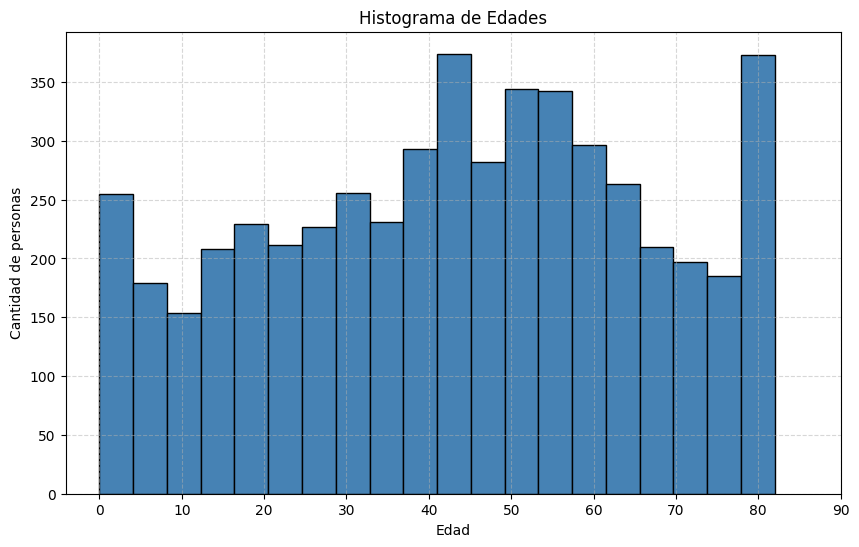

In [15]:
# Recolectamos todas las edades
edades = df04.select("edad").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.hist(edades, bins=20, color='steelblue', edgecolor='black')
plt.xlabel('Edad')
plt.xticks(np.arange(0, 91, 10))
plt.ylabel('Cantidad de personas')
plt.title('Histograma de Edades')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Este histograma muestra que la mayoria de las <code>edades</code> se concentran entre 40-70 años

2. Visualizar con una grafica la distribución de hombres y mujeres

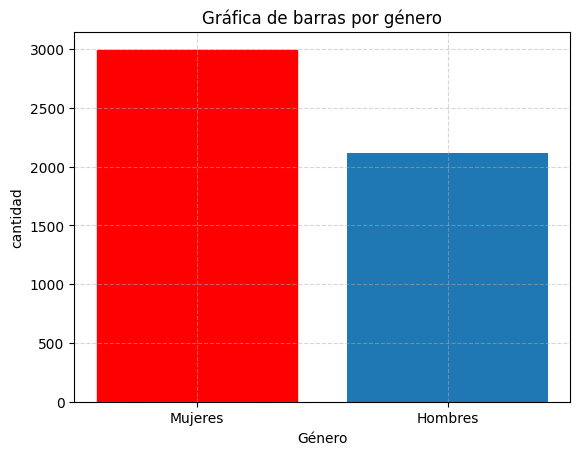

In [16]:
genero = df04.groupby('genero').count().select('count').rdd.flatMap(lambda x: x).collect()

categoria= ['Mujeres','Hombres']
grafica = plt.bar(categoria,genero)
grafica[0].set_color('r')
plt.ylabel('cantidad')
plt.xlabel('Género')
plt.title('Gráfica de barras por género')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Notamos que las mujeres predominan en la distribución

3. Visulizar con una grafica, si es más propenso a una enfermadad cardiaca según el historico en el dataset.



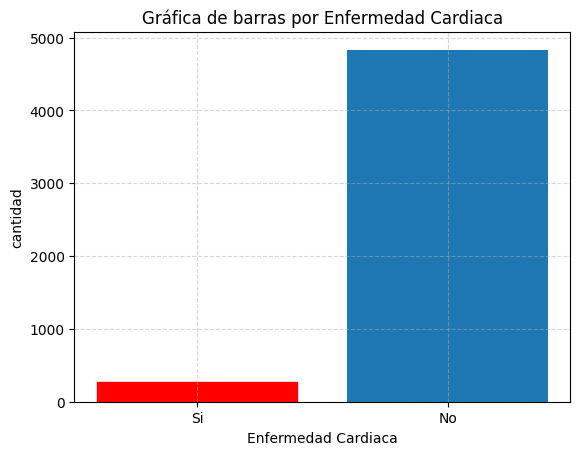

In [17]:
enfCardiaca = df04.groupby('enfCardiacas').count().select('count').rdd.flatMap(lambda x: x).collect()

categoria= ['Si','No']
grafica = plt.bar(categoria,enfCardiaca)
grafica[0].set_color('r')
plt.ylabel('cantidad')
plt.xlabel('Enfermedad Cardiaca')
plt.title('Gráfica de barras por Enfermedad Cardiaca')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

En el historico encontramos que hay mayor frecuencia en NO tener una enfermedad cardiaca

Importar librerias y Crear la etiqueta


In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, col
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

df_label = df04.withColumn("label", when(col("paracardiaco")==1, 1.0).otherwise(0.0))

Columnas

In [19]:
categoricalCols = ["genero", "estadoCivil", "tipoTrabajo", "tipoRecidencia", "fumador"]
numericCols     = ["edad", "hipertension", "enfCardiacas", "promedioGlucosa", "IMC"]

Index y OHE con handleInvalid="keep" para no perder categorías desconocidas

In [20]:
indexers = [
    StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep")
    for c in categoricalCols
]
encoders = [
    OneHotEncoder(inputCol=c+"_idx", outputCol=c+"_ohe", handleInvalid="keep")
    for c in categoricalCols
]


Imputer para los numéricos


In [21]:
imputer = Imputer(
    inputCols=numericCols,
    outputCols=numericCols
).setStrategy("mean")

Assembler


In [22]:
assembler = VectorAssembler(
    inputCols=[c+"_ohe" for c in categoricalCols] + numericCols,
    outputCol="features"
)

Pipeline completo


In [23]:
pipeline = Pipeline(stages=indexers + encoders + [imputer, assembler])
prepModel = pipeline.fit(df_label)
data = prepModel.transform(df_label).select("features", "label")

División de datos entrenamiento/prueba

In [24]:
entrenamiento, prueba = data.randomSplit([0.7, 0.3], seed=13)

 Entrenar Decision Tree

In [25]:
dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="label",
    maxDepth=4,
    seed=13
)
modelo = dt.fit(entrenamiento)

Predicciones y métricas


In [26]:
pred = modelo.transform(prueba)
pred.select("prediction","label","probability").show(5,False)

+----------+-----+-----------------------------------------+
|prediction|label|probability                              |
+----------+-----+-----------------------------------------+
|0.0       |0.0  |[0.7397260273972602,0.2602739726027397]  |
|0.0       |0.0  |[0.9898580121703854,0.010141987829614604]|
|0.0       |0.0  |[0.904228855721393,0.09577114427860696]  |
|0.0       |1.0  |[0.904228855721393,0.09577114427860696]  |
|0.0       |0.0  |[0.904228855721393,0.09577114427860696]  |
+----------+-----+-----------------------------------------+
only showing top 5 rows



Matriz de confusión


In [27]:
conf_df = (
    pred
    .groupBy("prediction","label")
    .count()
    .toPandas()
    .pivot(index="prediction",columns="label",values="count")
    .fillna(0)
)
TP = conf_df.loc[1.0,1.0]
FP = conf_df.loc[1.0,0.0]
TN = conf_df.loc[0.0,0.0]
FN = conf_df.loc[0.0,1.0]

accuracy    = (TP+TN)/(TP+TN+FP+FN)
sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)
precision   = TP/(TP+FP)

print(f"Accuracy    = {accuracy*100:.2f}%")
print(f"Sensitivity = {sensitivity*100:.2f}%")
print(f"Specificity = {specificity*100:.2f}%")
print(f"Precision   = {precision*100:.2f}%")

Accuracy    = 94.71%
Sensitivity = 2.50%
Specificity = 99.86%
Precision   = 50.00%


AUC Spark


AUC (Spark) = 68.27%


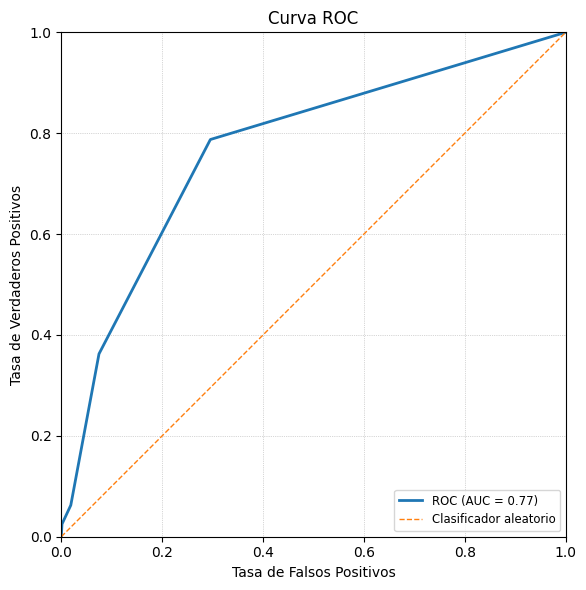

In [29]:
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc_spark = evaluator.evaluate(pred)
print(f"AUC (Spark) = {auc_spark*100:.2f}%")

# Curva ROC con sklearn/matplotlib
probs_labels = (
    pred
    .select("probability","label")
    .rdd
    .map(lambda r: (float(r.probability[1]), float(r.label)))
    .toDF(["probability","label"])
    .toPandas()
)
fpr, tpr, _ = roc_curve(probs_labels["label"], probs_labels["probability"])
roc_auc     = auc(fpr, tpr)

plt.figure(figsize=(6, 6))

# Curva ROC con mayor grosor de línea y eje 1:1
plt.plot(fpr, tpr,
         linewidth=2,
         label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         linewidth=1,
         label='Clasificador aleatorio')

# Ajustes de ejes
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.gca().set_aspect('equal', 'box')

# Etiquetas y título
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right', fontsize='small')

# Mejor distribución del layout
plt.tight_layout()

# Mostrar
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.show()


#Conclusiones

### Preprocesamiento

Se imputaron los valores faltantes y se codificaron las variables categóricas, obteniendo un dataset completamente limpio y listo para ser utilizado en el entrenamiento del modelo.

### Entrenamiento

Se entrenó un árbol de decisión con una profundidad máxima de 4, utilizando el 70 % del conjunto de datos. El modelo fue optimizado para diferenciar entre los casos etiquetados como “paracardíaco” y “no paracardíaco”.

### Predicciones y matriz de confusión

El modelo mostró una fuerte tendencia a predecir la clase negativa, lo que resultó en un alto número de verdaderos negativos, pero muy pocos verdaderos positivos. Esto sugiere un desbalance en las clases o una baja sensibilidad del modelo.

### Métricas de clasificación

- **Accuracy:** 94.71 %  
- **Sensibilidad (Recall):** 2.50 %  
- **Especificidad:** 99.86 %  
- **Precisión:** 50.00 %

Estas métricas reflejan un modelo altamente preciso para detectar casos negativos, pero con un rendimiento muy pobre al identificar correctamente los casos positivos.

### Curva ROC / AUC

El área bajo la curva (AUC) fue de aproximadamente 0.77, lo que indica una capacidad de discriminación moderada, claramente superior al azar, pero insuficiente para un modelo confiable en aplicaciones críticas.

---

**Conclusión:**  
Aunque el modelo alcanza una alta exactitud y especificidad, su baja sensibilidad lo limita gravemente para detectar casos positivos reales. Se recomienda mejorar el balance de clases, ajustar los pesos o explorar otros algoritmos más robustos como Random Forest o XGBoost para mejorar la detección de la clase minoritaria.
